In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_cos_graphsage_linkpred_11_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 256)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7ff4a009afc0> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(7167)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

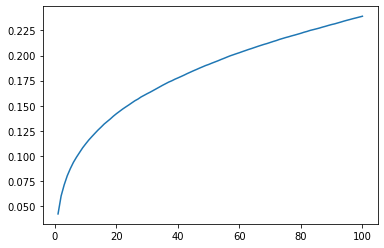

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.0424, 0.0603, 0.0713, 0.0804, 0.0875, 0.0937, 0.0988, 0.1035, 0.1082,
        0.1121, 0.1159, 0.1193, 0.1226, 0.1258, 0.1288, 0.1318, 0.1343, 0.1369,
        0.1397, 0.1421, 0.1444, 0.1467, 0.1488, 0.1508, 0.1529, 0.1550, 0.1567,
        0.1587, 0.1604, 0.1620, 0.1636, 0.1653, 0.1670, 0.1687, 0.1704, 0.1720,
        0.1736, 0.1749, 0.1764, 0.1777, 0.1791, 0.1805, 0.1820, 0.1834, 0.1848,
        0.1861, 0.1874, 0.1887, 0.1900, 0.1911, 0.1924, 0.1936, 0.1947, 0.1960,
        0.1972, 0.1985, 0.1997, 0.2007, 0.2018, 0.2028, 0.2039, 0.2050, 0.2060,
        0.2070, 0.2081, 0.2091, 0.2101, 0.2111, 0.2119, 0.2130, 0.2140, 0.2149,
        0.2160, 0.2169, 0.2178, 0.2186, 0.2195, 0.2204, 0.2212, 0.2221, 0.2231,
        0.2240, 0.2250, 0.2257, 0.2265, 0.2273, 0.2282, 0.2291, 0.2300, 0.2308,
        0.2315, 0.2324, 0.2333, 0.2342, 0.2351, 0.2359, 0.2367, 0.2375, 0.2383,
        0.2391])

In [18]:
percentages.max()

tensor(0.2391)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.47541381, 0.45736464, 0.44566747, 0.43773141, 0.43155607,
       0.42669218, 0.42246548, 0.41884961, 0.41556223, 0.41277585,
       0.41011546, 0.40782416, 0.40569004, 0.40372119, 0.40181131,
       0.40016785, 0.39862743, 0.3971125 , 0.39574865, 0.39437945,
       0.39308555, 0.39180136, 0.39063064, 0.3895287 , 0.38848515,
       0.38749189, 0.38654224, 0.38561887, 0.38471989, 0.38384954,
       0.38296677, 0.38214674, 0.38135565, 0.38057444, 0.37978034,
       0.3790361 , 0.37833465, 0.37760515, 0.37690701, 0.37625559,
       0.37562543, 0.37498408, 0.3743878 , 0.37378776, 0.37322043,
       0.37262281, 0.37202588, 0.37141187, 0.37087606, 0.37032402,
       0.36978621, 0.36927488, 0.36879666, 0.36833746, 0.36786726,
       0.36740373, 0.36691067, 0.36644531, 0.36598181, 0.36553514,
       0.36507542, 0.36463301, 0.36421702, 0.36380416, 0.3633831 ,
       0.36292756, 0.3625096 , 0.36209993, 0.36170787, 0.36132288,
       0.36097584, 0.36060171, 0.36025715, 0.35989654, 0.35954

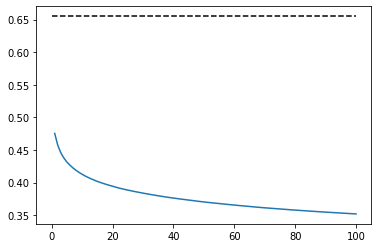

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7ff49802ed20> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(13697)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.9994488492429863

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  12093,  36054, ...,  79872,  56534,  15006],
       [     1, 154949,  97340, ...,  15027, 115387,  90950],
       [     2, 153753,  79805, ..., 161521, 152311,  61120],
       ...,
       [169340, 107677,  77178, ...,  73720,   7083, 102932],
       [169341,  70312, 111018, ...,  22898, 114485,  96061],
       [169342,  65348, 127946, ...,  17054, 144600, 132932]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.9988976984859725

In [40]:
distances

array([[1.0000002 , 0.9994188 , 0.99929047, ..., 0.99887085, 0.9988699 ,
        0.9988664 ],
       [1.0000004 , 0.999984  , 0.9999716 , ..., 0.9999409 , 0.99994075,
        0.99994075],
       [0.9999998 , 0.9999786 , 0.9999739 , ..., 0.99993163, 0.99993074,
        0.9999307 ],
       ...,
       [1.0000001 , 0.9998745 , 0.99972266, ..., 0.99949425, 0.99949336,
        0.99949235],
       [1.0000004 , 0.9999126 , 0.9998996 , ..., 0.9996875 , 0.9996843 ,
        0.9996841 ],
       [1.        , 0.99850786, 0.9982739 , ..., 0.99578726, 0.9957732 ,
        0.99576426]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

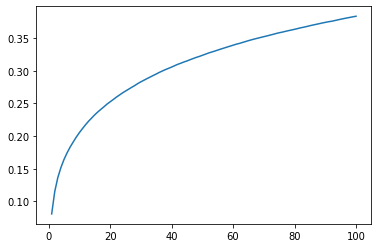

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.0808, 0.1150, 0.1365, 0.1517, 0.1640, 0.1741, 0.1831, 0.1908, 0.1983,
        0.2051, 0.2113, 0.2172, 0.2226, 0.2275, 0.2325, 0.2368, 0.2408, 0.2447,
        0.2489, 0.2523, 0.2558, 0.2594, 0.2626, 0.2658, 0.2688, 0.2716, 0.2745,
        0.2772, 0.2802, 0.2829, 0.2854, 0.2879, 0.2902, 0.2926, 0.2949, 0.2973,
        0.2995, 0.3017, 0.3036, 0.3055, 0.3076, 0.3097, 0.3114, 0.3133, 0.3149,
        0.3168, 0.3185, 0.3203, 0.3218, 0.3235, 0.3252, 0.3270, 0.3285, 0.3299,
        0.3315, 0.3331, 0.3345, 0.3361, 0.3375, 0.3390, 0.3405, 0.3417, 0.3431,
        0.3445, 0.3459, 0.3473, 0.3485, 0.3497, 0.3509, 0.3520, 0.3532, 0.3544,
        0.3556, 0.3569, 0.3580, 0.3590, 0.3602, 0.3612, 0.3623, 0.3633, 0.3644,
        0.3656, 0.3666, 0.3676, 0.3688, 0.3699, 0.3709, 0.3719, 0.3730, 0.3739,
        0.3749, 0.3756, 0.3766, 0.3777, 0.3787, 0.3797, 0.3807, 0.3815, 0.3825,
        0.3833])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.53535723, 0.51411927, 0.50087495, 0.49094294, 0.48320627,
       0.47713812, 0.47210522, 0.46747651, 0.46374584, 0.46055698,
       0.45774552, 0.45514183, 0.45285604, 0.45077109, 0.44900626,
       0.44729964, 0.44559371, 0.44410588, 0.44274514, 0.44146171,
       0.4402707 , 0.439079  , 0.43802018, 0.43693273, 0.43583567,
       0.43485638, 0.43395554, 0.43306801, 0.43217367, 0.43140155,
       0.43059791, 0.42988122, 0.4292008 , 0.4285123 , 0.42784256,
       0.42719674, 0.4265828 , 0.42594445, 0.42533066, 0.42476173,
       0.42422012, 0.42363498, 0.42312911, 0.42262463, 0.42212105,
       0.42163333, 0.42117126, 0.42068711, 0.42023392, 0.41978529,
       0.41936976, 0.41895659, 0.41852825, 0.41811425, 0.41773861,
       0.41738661, 0.4170021 , 0.41664052, 0.41628149, 0.41594486,
       0.41560455, 0.41523046, 0.41489129, 0.41456052, 0.41419622,
       0.41386873, 0.4135697 , 0.41324838, 0.41294947, 0.41264239,
       0.41232649, 0.41201503, 0.4117231 , 0.41145885, 0.41118

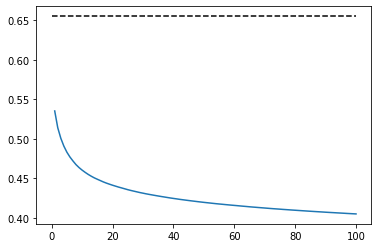

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [51]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [52]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [53]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7ff4801c89c0> >

In [54]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [55]:
distances, indices = index_ip.search(embeddings, 2)

In [56]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(14264)

In [57]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [58]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

4727.0527056147985

In [59]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [60]:
indices

array([[ 37296,  32436,  46600, ...,  26830, 100274,  24437],
       [  5497, 102903,  28974, ...,  21229, 128521,  15584],
       [123505,  14745, 158916, ..., 141783,  35849,  21508],
       ...,
       [ 32944,   3723,  24218, ...,  73205,  42495,  55379],
       [ 37296,  32436,  46600, ..., 152025, 100274,  24437],
       [128032,  12242,   4277, ...,  83835, 127636, 120097]])

In [61]:
sum(embeddings[0] * embeddings[411])

9453.105411229597

In [62]:
distances

array([[ 19059.604 ,  18728.752 ,  17271.404 , ...,  12529.118 ,
         12510.314 ,  12506.157 ],
       [ 90828.87  ,  79198.7   ,  78298.14  , ...,  43564.66  ,
         43544.84  ,  43489.2   ],
       [ 15974.559 ,  15069.76  ,  14870.404 , ...,  10493.115 ,
         10485.001 ,  10478.205 ],
       ...,
       [128898.31  , 103325.25  ,  97159.16  , ...,  56457.656 ,
         56347.996 ,  56247.7   ],
       [ 15527.594 ,  15281.942 ,  14081.223 , ...,  10232.988 ,
         10212.102 ,  10204.758 ],
       [  5432.8687,   4899.763 ,   4721.088 , ...,   3507.4363,
          3504.9927,   3503.9958]], dtype=float32)

In [63]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [64]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

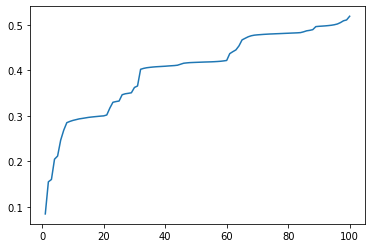

In [65]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [66]:
percentages

tensor([0.0842, 0.1548, 0.1600, 0.2046, 0.2115, 0.2464, 0.2685, 0.2850, 0.2878,
        0.2900, 0.2916, 0.2933, 0.2943, 0.2954, 0.2966, 0.2974, 0.2981, 0.2988,
        0.2994, 0.2999, 0.3019, 0.3172, 0.3298, 0.3315, 0.3326, 0.3465, 0.3485,
        0.3496, 0.3508, 0.3625, 0.3657, 0.4024, 0.4045, 0.4059, 0.4067, 0.4074,
        0.4080, 0.4084, 0.4088, 0.4092, 0.4097, 0.4102, 0.4107, 0.4114, 0.4136,
        0.4158, 0.4165, 0.4171, 0.4174, 0.4177, 0.4179, 0.4182, 0.4185, 0.4186,
        0.4189, 0.4192, 0.4196, 0.4201, 0.4209, 0.4219, 0.4369, 0.4412, 0.4451,
        0.4539, 0.4671, 0.4706, 0.4740, 0.4762, 0.4775, 0.4782, 0.4787, 0.4793,
        0.4797, 0.4801, 0.4803, 0.4806, 0.4809, 0.4812, 0.4815, 0.4818, 0.4821,
        0.4824, 0.4827, 0.4831, 0.4849, 0.4871, 0.4881, 0.4897, 0.4963, 0.4970,
        0.4974, 0.4979, 0.4985, 0.4993, 0.5004, 0.5021, 0.5052, 0.5092, 0.5110,
        0.5192])

### Percentage of same class neighbors by neighborhood size

In [67]:
ind_labels = label_transform(indices)

In [68]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [69]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [70]:
perc_same_class = n_same_class / n_total

In [71]:
perc_same_class

array([0.47286867, 0.45504686, 0.42212157, 0.36933915, 0.35572772,
       0.34895744, 0.33761402, 0.31651958, 0.31500236, 0.31165563,
       0.30317221, 0.29557614, 0.29587469, 0.2976052 , 0.29052475,
       0.28705386, 0.28233543, 0.27880495, 0.27592426, 0.27374914,
       0.26879174, 0.27003666, 0.26969164, 0.26719292, 0.26777109,
       0.26986626, 0.26927444, 0.2680711 , 0.2671611 , 0.26866852,
       0.26812312, 0.27064449, 0.27007961, 0.26933467, 0.26743001,
       0.26614868, 0.26629242, 0.26513038, 0.26531481, 0.26529219,
       0.26392717, 0.2640721 , 0.26547235, 0.26498425, 0.26429462,
       0.26382626, 0.26321864, 0.26269588, 0.2619474 , 0.26166101,
       0.26203865, 0.26159947, 0.26170364, 0.26070439, 0.26012091,
       0.25988695, 0.26017785, 0.26058772, 0.26024195, 0.25997669,
       0.25937008, 0.25907278, 0.25866915, 0.25922564, 0.25926597,
       0.25966744, 0.25845945, 0.25711009, 0.25587139, 0.25506019,
       0.25508849, 0.25616172, 0.25517206, 0.25419152, 0.25402

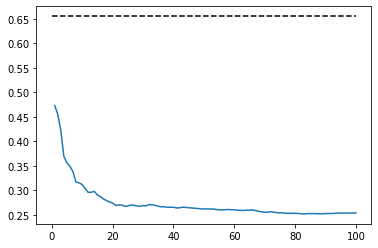

In [72]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [73]:
pca = PCA(n_components=2)

In [74]:
pca.fit(embeddings)

PCA(n_components=2)

In [75]:
emb_2d = pca.transform(embeddings)

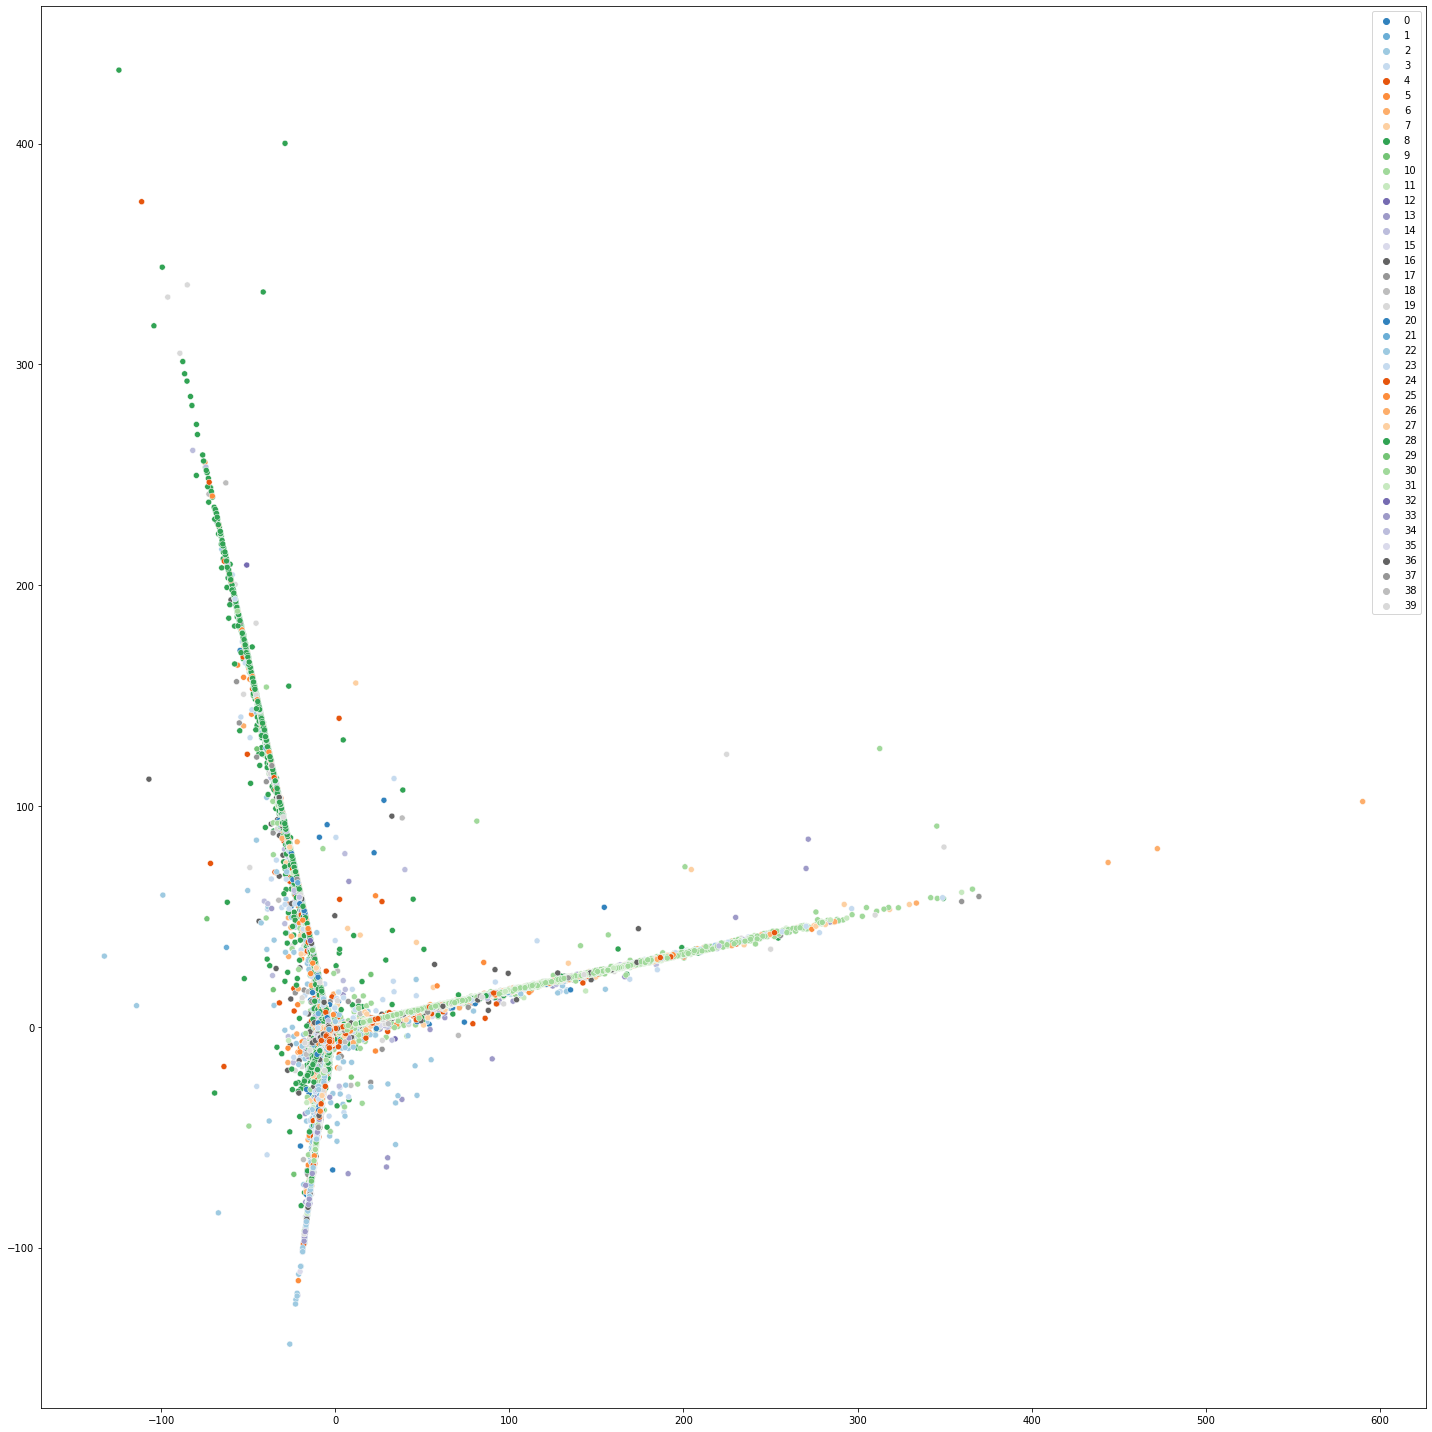

In [76]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [77]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

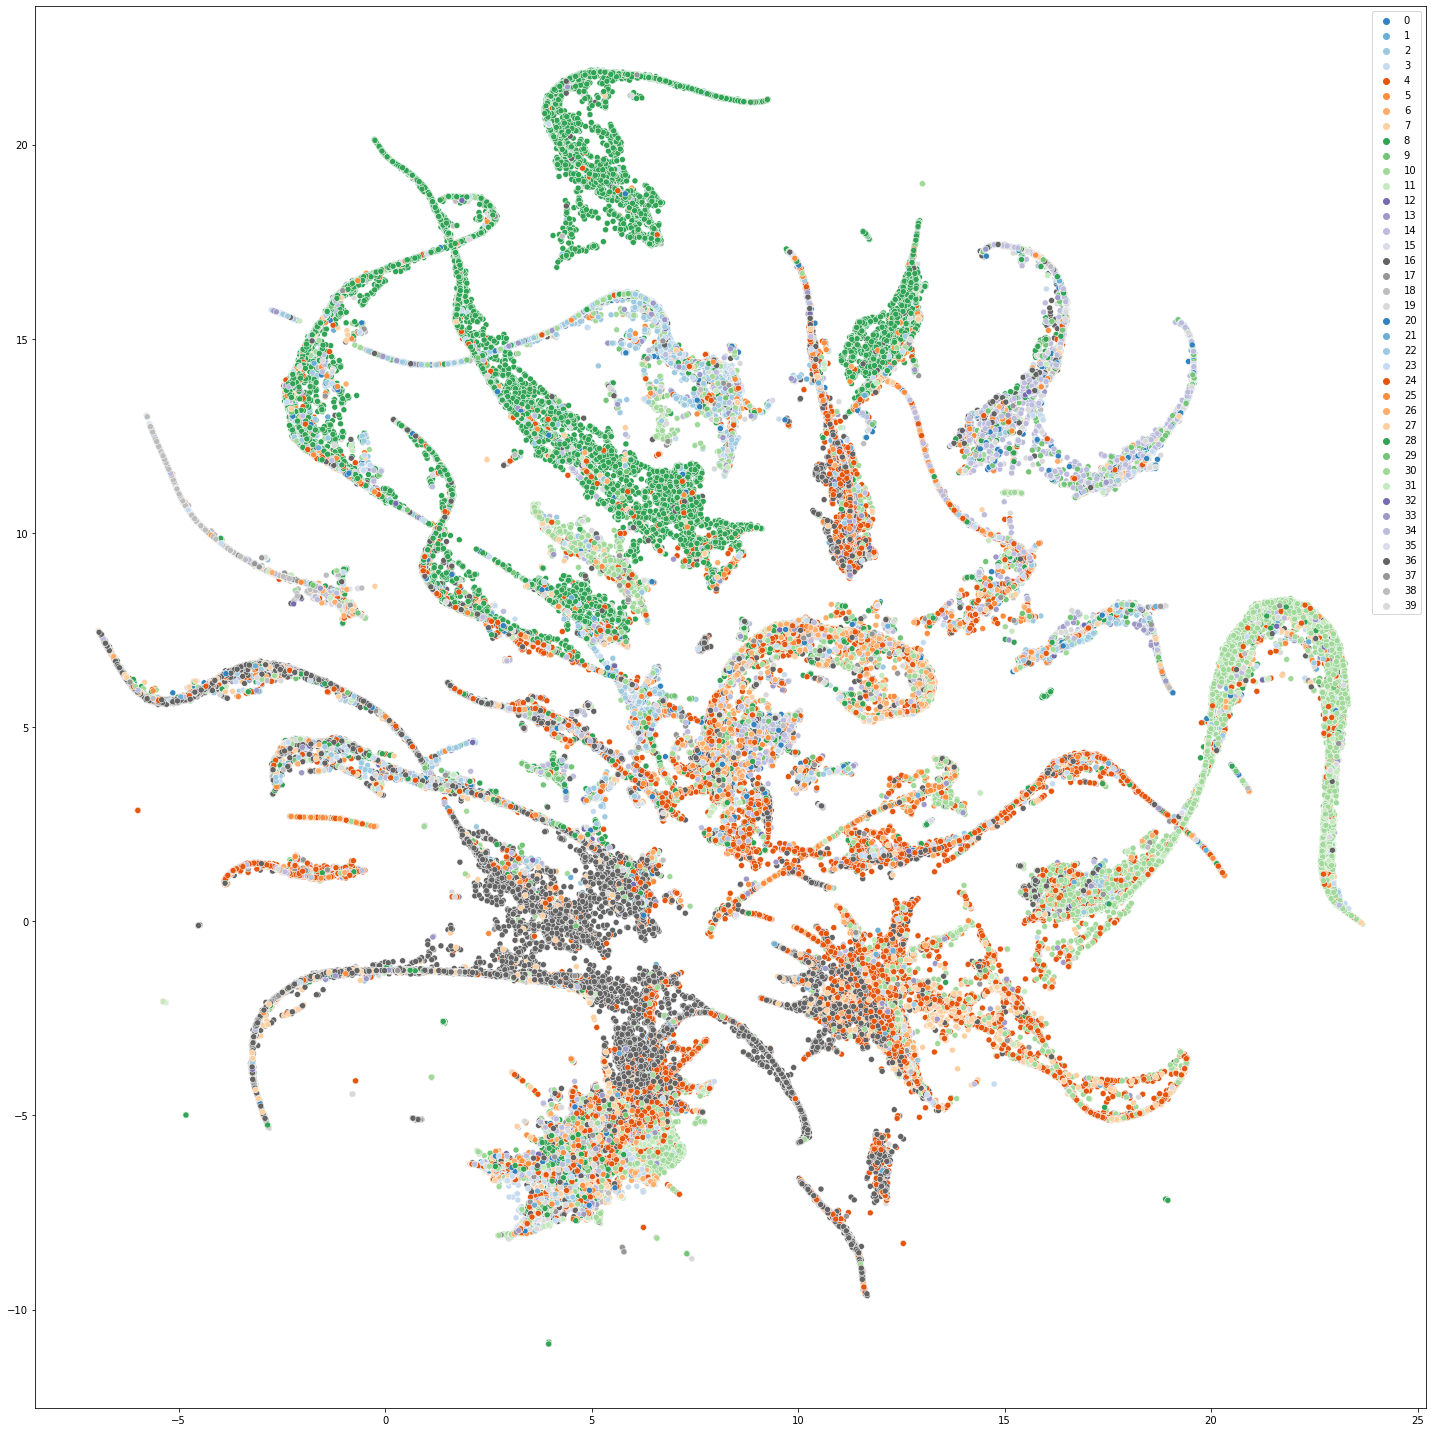

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

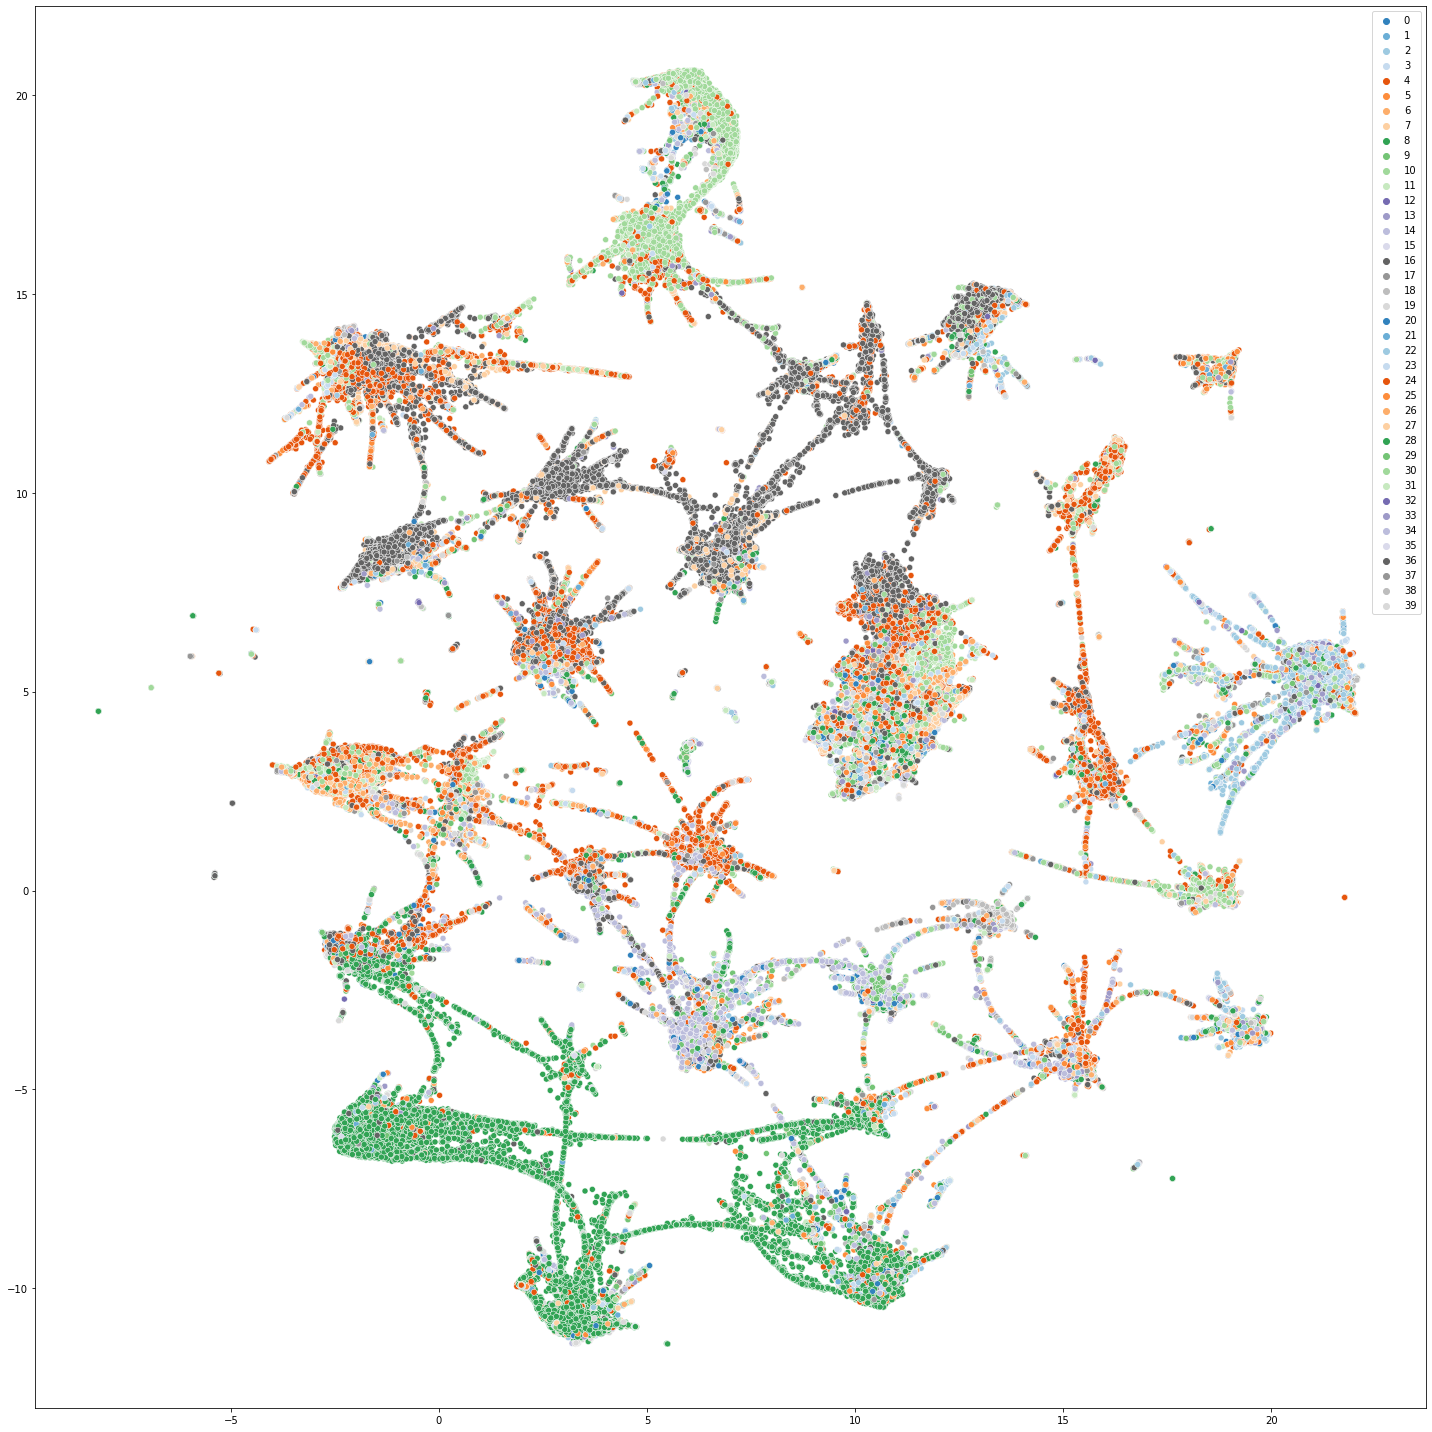

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()